In [1]:
import os
import cv2 as cv
from PIL import Image
import numpy as np
import pickle
from tqdm import tqdm

#CV2  4.1.2可以用绝对地址，新版本只能使用相对路径
data_dir = 'data/mini-imagenet'
dataset_train = "train.csv"
dataset_val = "val.csv"
dataset_test = "test.csv"

In [4]:
"""读取 CSV文件，以字典类型返回每一列的内容。"""
def read_csv_labels(fname):
    with open(fname, 'r') as f:
        # 跳过文件头行 (列名)
        lines = f.readlines()[1:]
    tokens = [row.rstrip().split(',') for row in lines]
    #return dict(((name, label) for name, label in tokens))
    fname = []
    flabel = []
    for name, label in tokens:
        fname.append(name)
        flabel.append(label)
    csv_dic = {'col_filename': fname, 'col_label' : flabel}
    return  csv_dic

In [5]:
train_data = read_csv_labels(os.path.join(data_dir, dataset_train))
val_data = read_csv_labels(os.path.join(data_dir, dataset_val))
test_data = read_csv_labels(os.path.join(data_dir, dataset_test))
print(train_data['col_filename'][0],train_data['col_label'][0])
print('image_number:',len(train_data['col_label']),len(val_data['col_label']),len(test_data['col_label']))

n0153282900000005.jpg n01532829
image_number: 38400 9600 12000


In [6]:
#求类别，并合并label
labels_train_set = set(train_data['col_label'])
labels_val_set = set(val_data['col_label'])
labels_test_set = set(test_data['col_label'])

print('[train_labels]=',list(labels_train_set),len(list(labels_train_set)))
print('%s类别数:' %dataset_train,len(labels_train_set))
print('%s类别数:' %dataset_val,len(labels_val_set))
print('%s类别数:' %dataset_test,len(labels_test_set))

print('train,val交集： ',labels_train_set & labels_val_set)
print('train,test交集： ',labels_train_set & labels_test_set)
print('val,test交集： ',labels_val_set & labels_test_set)

labels_list = list(labels_train_set) + list(labels_val_set) + list(labels_test_set)
print('数据集label总数：',len(labels_list))

[train_labels]= ['n04435653', 'n02108089', 'n09246464', 'n03347037', 'n03908618', 'n03924679', 'n04443257', 'n02105505', 'n02457408', 'n13133613', 'n03676483', 'n02795169', 'n01704323', 'n02120079', 'n02111277', 'n03838899', 'n02101006', 'n03854065', 'n03062245', 'n03527444', 'n13054560', 'n03017168', 'n01843383', 'n02074367', 'n02108915', 'n03337140', 'n02687172', 'n04596742', 'n07584110', 'n01910747', 'n03400231', 'n02165456', 'n04251144', 'n04243546', 'n02089867', 'n02108551', 'n02966193', 'n06794110', 'n01770081', 'n02823428', 'n02606052', 'n04258138', 'n04296562', 'n03207743', 'n01749939', 'n02747177', 'n03888605', 'n04067472', 'n04509417', 'n02113712', 'n04515003', 'n07747607', 'n07697537', 'n03047690', 'n02091831', 'n04275548', 'n03476684', 'n04604644', 'n03220513', 'n01532829', 'n04389033', 'n03998194', 'n01558993', 'n04612504'] 64
train.csv类别数: 64
val.csv类别数: 16
test.csv类别数: 20
train,val交集：  set()
train,test交集：  set()
val,test交集：  set()
数据集label总数： 100


In [7]:
#将类别转化为数字标号
labels_dict = {}
i = 1
for l in labels_list:
    if l not in labels_dict:
        labels_dict[l] = i
        i = i+1
print(labels_dict)

{'n04435653': 1, 'n02108089': 2, 'n09246464': 3, 'n03347037': 4, 'n03908618': 5, 'n03924679': 6, 'n04443257': 7, 'n02105505': 8, 'n02457408': 9, 'n13133613': 10, 'n03676483': 11, 'n02795169': 12, 'n01704323': 13, 'n02120079': 14, 'n02111277': 15, 'n03838899': 16, 'n02101006': 17, 'n03854065': 18, 'n03062245': 19, 'n03527444': 20, 'n13054560': 21, 'n03017168': 22, 'n01843383': 23, 'n02074367': 24, 'n02108915': 25, 'n03337140': 26, 'n02687172': 27, 'n04596742': 28, 'n07584110': 29, 'n01910747': 30, 'n03400231': 31, 'n02165456': 32, 'n04251144': 33, 'n04243546': 34, 'n02089867': 35, 'n02108551': 36, 'n02966193': 37, 'n06794110': 38, 'n01770081': 39, 'n02823428': 40, 'n02606052': 41, 'n04258138': 42, 'n04296562': 43, 'n03207743': 44, 'n01749939': 45, 'n02747177': 46, 'n03888605': 47, 'n04067472': 48, 'n04509417': 49, 'n02113712': 50, 'n04515003': 51, 'n07747607': 52, 'n07697537': 53, 'n03047690': 54, 'n02091831': 55, 'n04275548': 56, 'n03476684': 57, 'n04604644': 58, 'n03220513': 59, 'n015

In [7]:
"""
读取图像文件，存入list中
下面直接封装成  get_image(path,_data)函数
"""
images = []
labels = []
i = 0
with tqdm(total=len(train_data['col_filename'])) as pbar:
    pbar.set_description('Processing:')
    for fname,flabel in zip(train_data['col_filename'],train_data['col_label']):
        fall_path = os.path.join(data_dir, 'images', fname)
        image = cv.imread(fall_path)#读取图片
        #image = Image.open(fall_path)
        images.append(image)#存入数组
        labels.append(labels_dict[flabel])#存入数组
        pbar.update(1)#更新进度条
        i+=1
        #if i==3:
         #   img0=Image.open(fall_path)
          #  img0.show()
        if i==2:
            cv.imshow("image",image)
            cv.waitKey(0)
print(len(images))
print(os.path.join(data_dir, 'images', train_data['col_filename'][0]))
print(set(labels))

Processing:: 100%|██████████| 38400/38400 [02:06<00:00, 304.24it/s]

38400
data/mini-imagenet/images/n0153282900000005.jpg
{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64}


In [8]:
print(images[0].shape,labels[0])
#cv.imshow("image label: %s" %labels[0],images[0])

#cv.waitKey(0)

(357, 500, 3) 52


In [8]:
#对应图像小于crop高宽的,筛选出来
def filter(imgs,crop_size):
    return [img for img in imgs if (
        img.shape[0] < crop_size[0] or img.shape[1] < crop_size[1])]

In [ ]:
small_image = filter(images,[84,84])
print('小图片数量：',len(small_image))
print(small_image[1].shape)
Image.fromarray(small_image[1]).show()
Image.fromarray(cv.resize(small_image[1],(84,84))).show()

In [9]:
"""
读取图像文件，存入list中
"""
def get_image(path,_data):
    images = []
    labels = []
    crop_size = [84,84]
    with tqdm(total=len(_data['col_filename'])) as pbar:
        pbar.set_description('Getting image processing:')
        for fname,flabel in zip(_data['col_filename'],_data['col_label']):
            fall_path = os.path.join(path, 'images', fname)
            image = cv.imread(fall_path)
            #if(image.shape[0] < crop_size[0] or image.shape[1] < crop_size[1]):
             #   image = cv.resize(image,(84,84))#resize成（84，84）满足后续crop的需要
            image = cv.resize(image,(84,84))#resize成（84，84）
            images.append(image)
            labels.append(labels_dict[flabel])
            pbar.update(1)#更新进度条
    return images, labels

In [15]:
"""
写入.pickle文件
"""
images, labels = get_image(data_dir,test_data)#替换上面读取的csv数据
images = np.asarray(images,dtype=object)
print(images.shape)
small_image = filter(images,[84,84])
print('小图片数量：',len(small_image))
train_dic = {'data': images, 'labels' : labels}
#train.csv  miniImageNet_category_split_train_phase_train.pickle
#val.csv  miniImageNet_category_split_train_phase_val.pickle
#test.csv  miniImageNet_category_split_test.pickle
with open('miniImageNet_category_split_test.pickle', 'wb') as f:
    pickle.dump(train_dic, f)
    f.close()

Getting image processing:: 100%|██████████| 12000/12000 [00:37<00:00, 323.32it/s]


(12000, 84, 84, 3)
小图片数量： 0


In [19]:
'''
#测试--写pickle文件
a = 'owoof'
with open('111.pkl', 'wb') as file:
    pickle.dump(a, file)
'''

小图片数量： 0


In [10]:
import matplotlib.pyplot as plt

In [2]:
"""
读取.pickle文件
"""
path='miniImageNet_category_split_train_phase_train.pickle'
#path='miniImageNet_category_split_train_phase_val.pickle'
#path='miniImageNet_category_split_test.pickle'
with open(path,'rb') as f:
    data = pickle.load(f, encoding='bytes')
    imgs = data['data']
    labels = data['labels']
print(imgs.shape)
print(imgs[0].shape)

(38400, 84, 84, 3)
(84, 84, 3)


[31, 31, 31, 31, 31, 31, 31, 31, 31, 31]


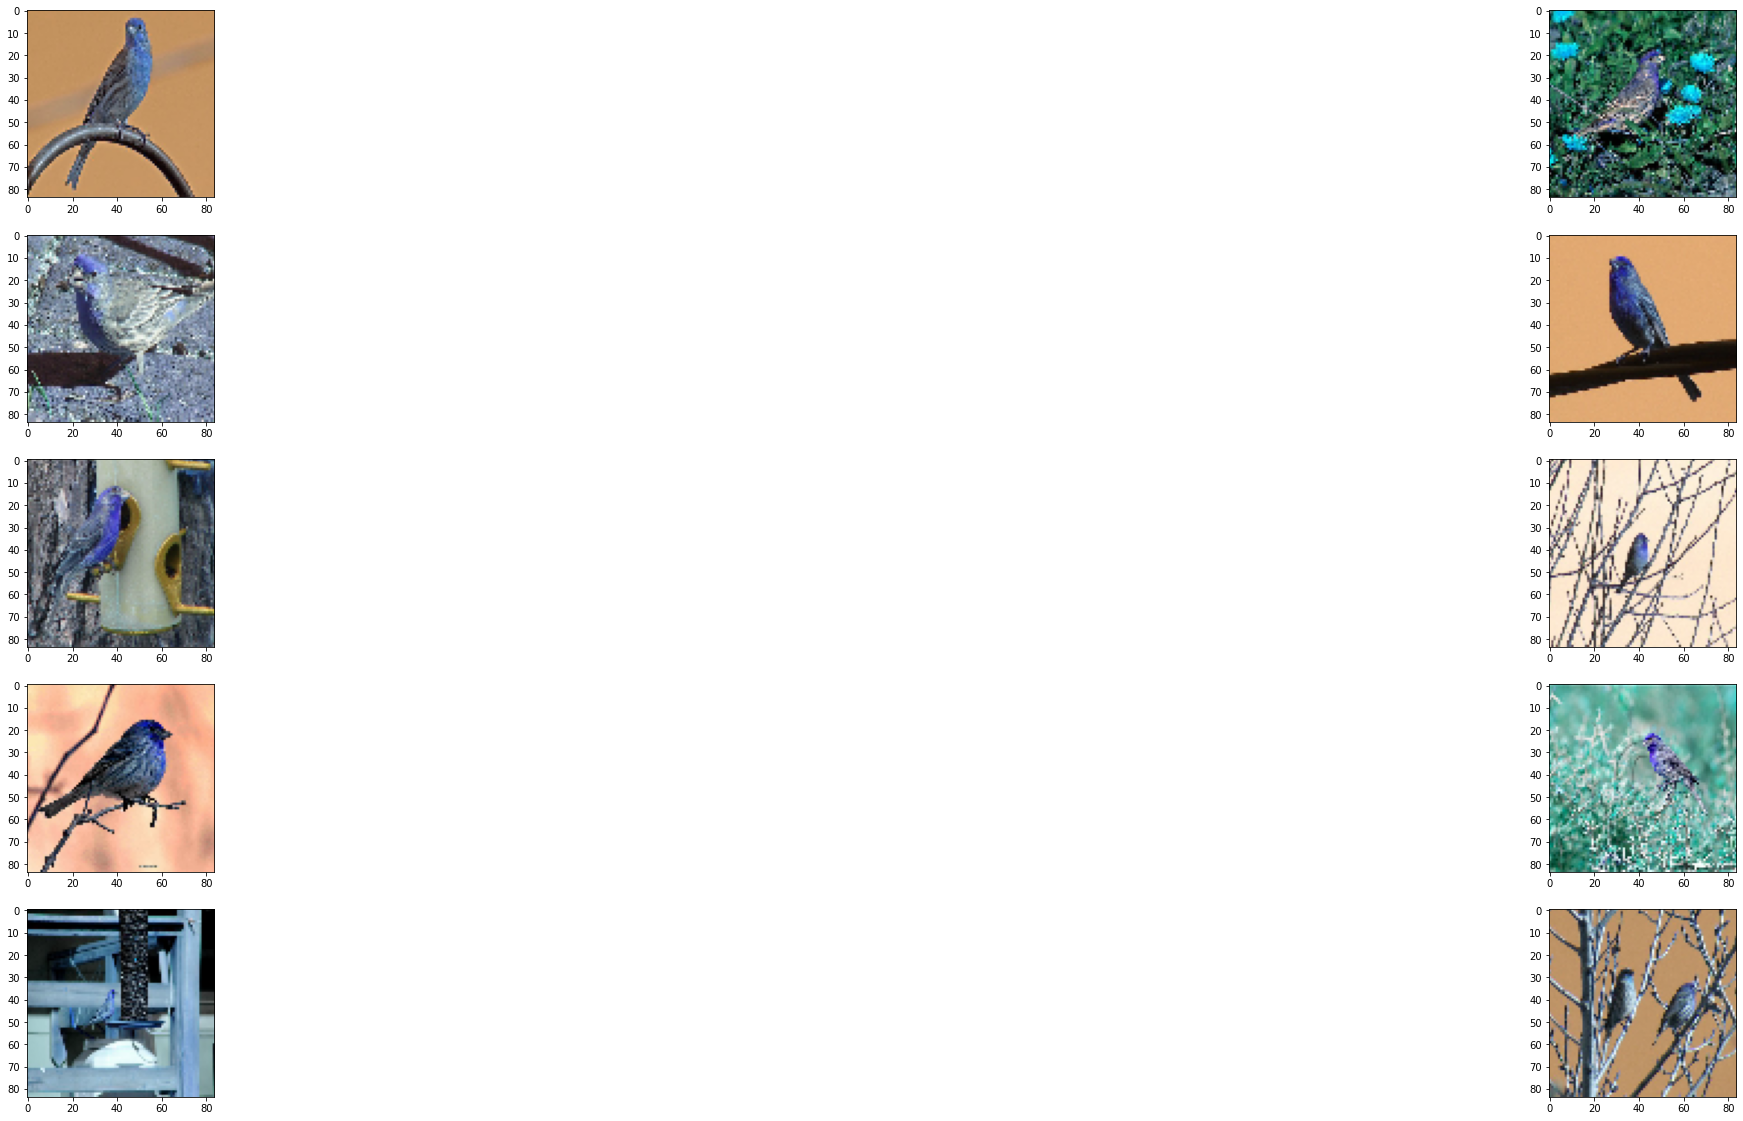

In [12]:
#测试生成的数据正确不
def test(train_dataset,train_label):
    print(train_label[:10])
    plt.figure(figsize=(50,20))
    for i in range(10):
        plt.subplot(5,2,i+1)
        plt.imshow(np.asarray(train_dataset[i]).astype('uint8'))
    plt.show()
    
test(imgs,labels)

In [18]:
item = 0
img = np.asarray(imgs[item]).astype('uint8')
img = Image.fromarray(img)
img.show()

In [13]:
slabels = np.asarray(labels)
print(slabels)
np.min(slabels)
slabels = slabels - np.min(slabels)
numclass = np.max(slabels)+1
print('number of class=',numclass)

[31 31 31 ... 16 16 16]
number of class= 64
